### Momentum

Momentum factors have been heavily researched since Jegadeesh and Titman's seminal 1993 paper 'Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency'. There are two main ways to define momentum. Where $P$ is the price of a stock:
- $P_{T-n} \to P_{T-2}$ returns, where $T$ is defined in months. The lookback $n$ is usually $12$ months.
- $P_{T-2} \to P_{T-1}$ returns; we'll see in our research why segmenting these two are important

Importantly, the strength of momentum (and perhaps, of all factors) is cyclical. The way we interpret the above two factors is inverse:
- $P_{T-12} \to P_{T-2}$ suggests *positive* momentum; previous winners are future winners
- $P_{T-2} \to P_{T-1}$ is short-term reversal; that is previous winners are future losers

#### Performance analysis of our factors

We consider the cross-sectional rank IC of the $P_{T-12} \to P_{T-2}$ factor (that is, we take the returns $P_{T-12} \to P_{T-2}$ for each stock), and then rank them by returns. We then see how predictive this is of the ranking of the future 3-month returns.

In [8]:
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os
from cycler import cycler


# i like viridis :)
inferno_colors = [
    "#000004",  # near black / deep purple
    "#420a68",  # violet
    "#932667",  # magenta/red
    "#f1605d",  # orange/red
    "#fcffa4",  # bright yellow
]
plt.rcParams["axes.prop_cycle"] = cycler(color=inferno_colors)

load_dotenv('../.env')
db_url = os.getenv('DB_URL')
psql = create_engine(db_url)

In [48]:
stock_data = pd.read_sql("select * from eom_prices", psql)

In [49]:
# get monthly constituents
monthly_constituents = pd.read_sql("select * from monthly_constituents", psql)

In [50]:
# sort by ticker and date, so we can group by ticker and get momentum factors
stock_data = stock_data.sort_values(['ticker', 'date'])

# get per-month return
stock_data['return'] = stock_data.groupby('ticker')['price'].transform(lambda x: x.pct_change())
# get momentum
stock_data['momentum'] = stock_data.groupby('ticker')['price'].transform(lambda x: x.shift(2) / x.shift(12) - 1)
# get short-term momentum (our reversal factor)
stock_data['reversal'] = stock_data.groupby('ticker')['price'].transform(lambda x: x.shift(1) / x.shift(2) - 1)
# get forward return
stock_data['return_t_plus_3'] = stock_data.groupby('ticker')['price'].transform(lambda x: x.shift(-3) / x - 1)

Now we have the total return between $P_{T-12} \to P_{T-2}$, the future return $P_{T+0} \to P_{T+3}$. Consider the rank IC of both of the factors.

In [51]:
stock_data = stock_data.merge(monthly_constituents, on=['date', 'ticker'])
stock_data = stock_data.dropna()

rank_ic = []

for date, data in stock_data.groupby('date'):
    rank_ic.append({
        'date': date,
        'momentum_ic': data['momentum'].corr(data['return_t_plus_3'], method='spearman'),
        'reversal_ic': data['reversal'].corr(data['return_t_plus_3'], method='spearman')
    })

rank_df = pd.DataFrame(rank_ic)

In [52]:
rank_df = rank_df.sort_values('date')

# get 1-year rolling performance measures
rank_df['momentum_rolling'] = rank_df['momentum_ic'].rolling(window=12).mean()
rank_df['reversal_rolling'] = rank_df['reversal_ic'].rolling(window=12).mean()

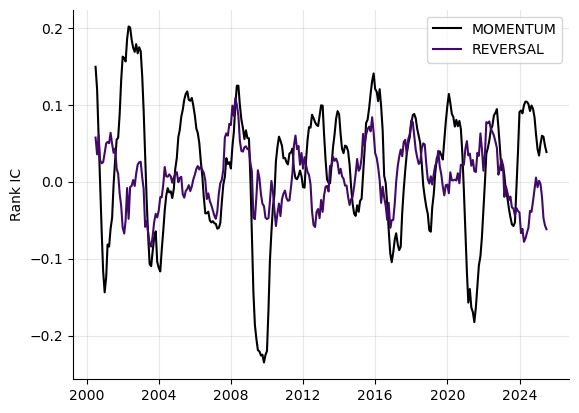

In [54]:
plt.plot(rank_df['date'], rank_df['momentum_rolling'], label='MOMENTUM')
plt.plot(rank_df['date'], rank_df['reversal_rolling'], label='REVERSAL')
plt.legend()
plt.grid(alpha=0.3)
plt.ylabel('Rank IC')
sns.despine()

We can see that our momentum factor works quite well, but our reversal factor appears to fall apart for 3-month horizons. We can observe this due to the fact it has positive rank IC, when for a reversal factor (that is not flipped for a positive signal), we should expect a negative rank IC. How does a momentum-only portfolio perform across our history?

We will take a market-neutral portfolio buying winners and selling losers, similar to how the portfolio is constructed in `Value and Momentum Everywhere` by `AQR`. We have a rank score $r_{it}$ for some stock $i$ and time $t$. The rank is given by the cross-sectional rank of the momentum $m_{it}$, such that

$$ r_{it} = \text{rank}(m_{it})$$

They then assign weights $w$ such that

$$ w_{it} = c_t\left(r_{it} - \frac{\sum_{j} r_{jt}}{N}\right)$$

where $c_t$ is a scaling factor such that the portfolio becomes `100/100`, and $N$ is the number of stocks in the universe. We require 

$$ \sum_{i=1}^N |w_{it}| = 2$$

for a net `100/100` exposure, and therefore

$$ c_t = \frac{2}{\sum_{i=1}^N |r_{it}|}$$

In [59]:
quintile_returns = []

for date, data in stock_data.groupby('date'):
    signal = data['momentum']

    # assign each stock to a quintile based on signal
    data = data.assign(quintile=pd.qcut(signal, 5, labels=False, duplicates="drop"))

    # just for display's sake - quintile 1 should be the best performing one
    data['quintile'] = 4 - data['quintile']
    
    # compute equal-weighted return per quintile
    qret = data.groupby('quintile')['return'].mean()

    quintile_returns.append(
        {"date": date,
         "Q1": qret.get(0, np.nan),
         "Q2": qret.get(1, np.nan),
         "Q3": qret.get(2, np.nan),
         "Q4": qret.get(3, np.nan),
         "Q5": qret.get(4, np.nan)}
    )

quintile_returns_df = pd.DataFrame(quintile_returns).sort_values("date")

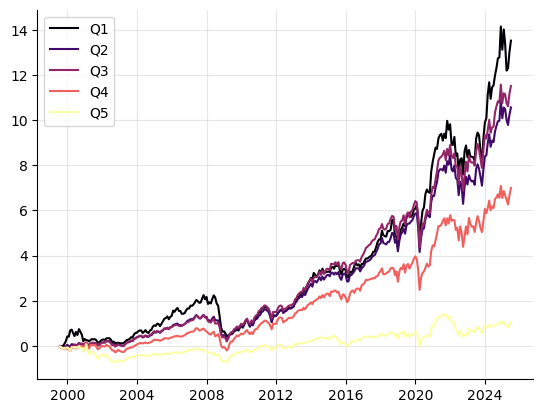

In [61]:
quintiles = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

for q in quintiles:
    plt.plot(quintile_returns_df['date'], (1 + quintile_returns_df[q]).cumprod() - 1, label=q)

plt.legend()
plt.grid(alpha=0.3)
sns.despine()

Now let's z-score the momentum across each day, and save it to the database.

In [40]:
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

momentum_factor = []

for date, data in stock_data.groupby('date'):
    data_copy = data.copy()
    data_copy['momentum'] = pd.Series(
        winsorize(data_copy['momentum'], limits=[0.01, 0.01]).data,
        index=data_copy.index
    )
    data_copy['momentum'] = zscore(data_copy['momentum'])
    data_copy['factor'] = 'MOMENTUM'
    data_copy = data_copy.rename(columns={'momentum': 'score'})
    momentum_factor.append(data_copy[['date', 'ticker', 'factor', 'score']])

momentum_factor_df = pd.concat(momentum_factor)

In [ ]:
# only run below if you haven't yet saved to database
# momentum_factor_df.to_sql('factor_scores', psql, if_exists='append', index=False)

970